In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [16]:
# Đọc tệp CSV
file_path = "../dataset/data.csv"
data = pd.read_csv(file_path)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


In [17]:
# Lọc dữ liệu cho Cửa hàng 1 và Bộ phận 1
store_1_dept_1 = data[(data['Store'] == 1) & (data['Dept'] == 1)]
store_1_dept_1 = store_1_dept_1.sort_index()  # Sắp xếp theo thời gian

sales_data = store_1_dept_1['Weekly_Sales']
exogenous_vars = store_1_dept_1[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size',
                                 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']]

# Xử lý giá trị thiếu nếu có
exogenous_vars = exogenous_vars.fillna(0)


In [18]:
# Chuẩn hóa dữ liệu
scaler_sales = MinMaxScaler(feature_range=(0, 1))
scaler_exog = MinMaxScaler(feature_range=(0, 1))

sales_scaled = scaler_sales.fit_transform(sales_data.values.reshape(-1, 1))
exog_scaled = scaler_exog.fit_transform(exogenous_vars)

# Kết hợp doanh số và biến ngoại sinh
dataset = np.concatenate([sales_scaled, exog_scaled], axis=1)

# Hàm tạo dữ liệu cho mô hình LSTM
def create_dataset(data, look_back=10):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        Y.append(data[i + look_back, 0])  # Doanh số là cột đầu tiên
    return np.array(X), np.array(Y)

look_back = 10  # Sử dụng 10 tuần dữ liệu để dự báo tuần tiếp theo

# Tạo dữ liệu cho mô hình
X, y = create_dataset(dataset, look_back)


In [19]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

n_features = dataset.shape[1]  # Số lượng biến đặc trưng

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, n_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=500, batch_size=1, verbose=2)

# Dự báo trên toàn bộ dữ liệu
y_pred_scaled = model.predict(X)
y_pred = scaler_sales.inverse_transform(y_pred_scaled)
y_actual = scaler_sales.inverse_transform(y.reshape(-1, 1))

# Tính toán RMSE, MAE, MAPE trên tập kiểm tra
y_test_pred = y_pred[train_size:]
y_test_actual = y_actual[train_size:]

rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
mae = mean_absolute_error(y_test_actual, y_test_pred)
mape = np.mean(np.abs((y_test_actual - y_test_pred) / y_test_actual)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")



Epoch 1/500


106/106 - 1s - 6ms/step - loss: 0.0547
Epoch 2/500
106/106 - 0s - 942us/step - loss: 0.0503
Epoch 3/500
106/106 - 0s - 974us/step - loss: 0.0474
Epoch 4/500
106/106 - 0s - 1ms/step - loss: 0.0438
Epoch 5/500
106/106 - 0s - 948us/step - loss: 0.0388
Epoch 6/500
106/106 - 0s - 956us/step - loss: 0.0353
Epoch 7/500
106/106 - 0s - 946us/step - loss: 0.0347
Epoch 8/500
106/106 - 0s - 930us/step - loss: 0.0289
Epoch 9/500
106/106 - 0s - 941us/step - loss: 0.0294
Epoch 10/500
106/106 - 0s - 961us/step - loss: 0.0292
Epoch 11/500
106/106 - 0s - 971us/step - loss: 0.0271
Epoch 12/500
106/106 - 0s - 961us/step - loss: 0.0254
Epoch 13/500
106/106 - 0s - 939us/step - loss: 0.0254
Epoch 14/500
106/106 - 0s - 941us/step - loss: 0.0251
Epoch 15/500
106/106 - 0s - 930us/step - loss: 0.0259
Epoch 16/500
106/106 - 0s - 939us/step - loss: 0.0239
Epoch 17/500
106/106 - 0s - 933us/step - loss: 0.0235
Epoch 18/500
106/106 - 0s - 968us/step - loss: 0.0212
Epoch 19/500
106/106 - 0s - 984us/step - loss: 0.0199

In [21]:
# Step 4: Tính tầm quan trọng của các biến

# Tạo lớp bao bọc cho mô hình Keras
class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model, look_back, n_features, scaler_sales):
        self.model = model
        self.look_back = look_back
        self.n_features = n_features
        self.scaler_sales = scaler_sales
    
    def fit(self, X, y):
        # Mô hình đã được huấn luyện, không cần làm gì
        pass
    
    def predict(self, X):
        X_reshaped = X.reshape(X.shape[0], self.look_back, self.n_features)
        y_pred_scaled = self.model.predict(X_reshaped)
        y_pred = self.scaler_sales.inverse_transform(y_pred_scaled)
        return y_pred.flatten()

# Chuyển đổi X thành dạng 2D để sử dụng permutation importance
X_reshaped = X.reshape(X.shape[0], look_back * n_features)

# Tạo tên cho các biến
feature_names = []
for i in range(look_back):
    for j in range(n_features):
        if j == 0:
            feature_names.append(f"Week_{i+1}_Sales")
        else:
            feature_names.append(f"Week_{i+1}_{exogenous_vars.columns[j-1]}")

# Tạo đối tượng estimator
estimator = KerasRegressorWrapper(model, look_back, n_features, scaler_sales)

# Tính tầm quan trọng của các biến
result = permutation_importance(estimator, X_reshaped, y_actual.flatten(), n_repeats=10, random_state=42)

# Tạo DataFrame cho tầm quan trọng của các biến
coef_df = pd.DataFrame({
    'Variable': feature_names,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# In tầm quan trọng của từng biến
print("\nTầm quan trọng của các biến:")
print(coef_df.head(20))  # In top 20 biến quan trọng nhất


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [22]:
# In tầm quan trọng của từng biến
print("\nTầm quan trọng của các biến:")
print(coef_df.head(20))  # In top 20 biến quan trọng nhất


Tầm quan trọng của các biến:
                Variable  Importance
99         Week_10_Sales    0.372609
88          Week_9_Sales    0.276192
100  Week_10_Temperature    0.166877
33          Week_4_Sales    0.127775
78    Week_8_Temperature    0.092956
89    Week_9_Temperature    0.088436
25            Week_3_CPI    0.072847
36            Week_4_CPI    0.069093
92   Week_9_Unemployment    0.065004
14            Week_2_CPI    0.058985
1     Week_1_Temperature    0.058285
0           Week_1_Sales    0.056445
77          Week_8_Sales    0.055469
22          Week_3_Sales    0.053779
67    Week_7_Temperature    0.050102
47            Week_5_CPI    0.045188
44          Week_5_Sales    0.044419
66          Week_7_Sales    0.039766
81   Week_8_Unemployment    0.038802
3             Week_1_CPI    0.038295


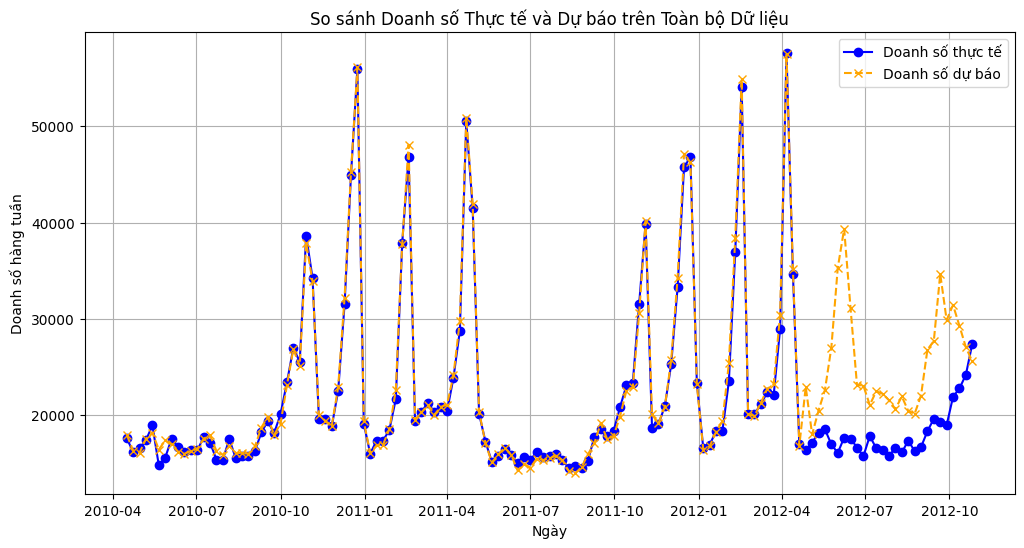

In [23]:

# Vẽ đồ thị so sánh trên toàn bộ dữ liệu
dates = sales_data.index[look_back:]

plt.figure(figsize=(12, 6))
plt.plot(dates, y_actual, label='Doanh số thực tế', color='blue', marker='o', linestyle='-')
plt.plot(dates, y_pred, label='Doanh số dự báo', color='orange', marker='x', linestyle='--')
plt.xlabel('Ngày')
plt.ylabel('Doanh số hàng tuần')
plt.title('So sánh Doanh số Thực tế và Dự báo trên Toàn bộ Dữ liệu')
plt.legend()
plt.grid()
plt.show()


In [24]:
# Dự báo cho 10 tuần tiếp theo
n_weeks_to_predict = 10

last_data = dataset[-look_back:]  # Lấy 10 tuần dữ liệu cuối cùng
predictions_future = []
future_dates = []

for i in range(n_weeks_to_predict):
    # Dự báo tuần tiếp theo
    next_pred_scaled = model.predict(last_data.reshape(1, look_back, n_features))
    next_pred = scaler_sales.inverse_transform(next_pred_scaled)[0][0]
    predictions_future.append(next_pred)

    # Ngày cho tuần tiếp theo
    next_date = sales_data.index[-1] + pd.Timedelta(weeks=i+1)
    future_dates.append(next_date)

    # Giả định biến ngoại sinh trong tương lai bằng giá trị trung bình
    future_exog_scaled = np.mean(exog_scaled[-look_back:], axis=0).reshape(1, -1)
    # Tạo dữ liệu cho lần dự báo tiếp theo
    next_input = np.concatenate([next_pred_scaled, future_exog_scaled], axis=1)
    last_data = np.vstack([last_data[1:], next_input])

# Tạo DataFrame cho kết quả dự báo tương lai
future_df = pd.DataFrame({'Predicted_Weekly_Sales': predictions_future}, index=future_dates)

# In kết quả dự báo cho 10 tuần tiếp theo
print("\nDoanh số dự báo cho 10 tuần tiếp theo:")
print(future_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Doanh số dự báo cho 10 tuần tiếp theo:
            Predicted_Weekly_Sales
2012-11-02            22524.652344
2012-11-09            22211.986328
2012-11-16            21507.757812
2012-11-23            22041.513672
2012-11-30            23576.099609
2012-12-07            25536.857422
2012-12-14            29046.697266
2012-12-21            34353.218750
2012-12-28            34832.410156
2013-01-04            26547.878906


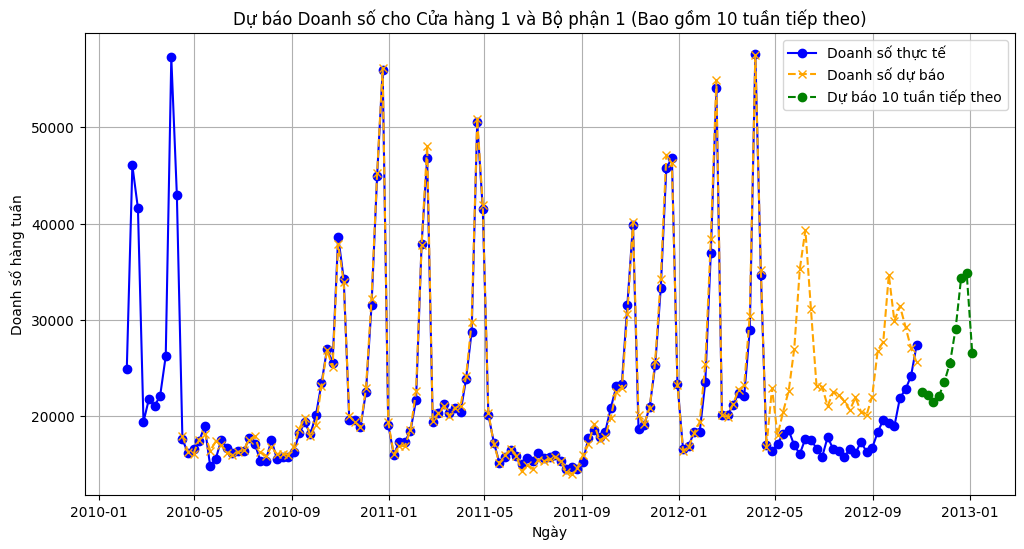

In [25]:
# Vẽ đồ thị bao gồm dự báo 10 tuần tiếp theo
plt.figure(figsize=(12, 6))
plt.plot(sales_data.index, sales_data.values, label='Doanh số thực tế', color='blue', marker='o', linestyle='-')
plt.plot(dates, y_pred, label='Doanh số dự báo', color='orange', marker='x', linestyle='--')
plt.plot(future_df.index, future_df['Predicted_Weekly_Sales'], label='Dự báo 10 tuần tiếp theo', color='green', marker='o', linestyle='--')
plt.xlabel('Ngày')
plt.ylabel('Doanh số hàng tuần')
plt.title('Dự báo Doanh số cho Cửa hàng 1 và Bộ phận 1 (Bao gồm 10 tuần tiếp theo)')
plt.legend()
plt.grid()
plt.show()

Epoch 1/50


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


106/106 - 1s - 7ms/step - loss: 0.0596
Epoch 2/50
106/106 - 0s - 915us/step - loss: 0.0508
Epoch 3/50
106/106 - 0s - 918us/step - loss: 0.0447
Epoch 4/50
106/106 - 0s - 983us/step - loss: 0.0448
Epoch 5/50
106/106 - 0s - 960us/step - loss: 0.0402
Epoch 6/50
106/106 - 0s - 947us/step - loss: 0.0389
Epoch 7/50
106/106 - 0s - 960us/step - loss: 0.0338
Epoch 8/50
106/106 - 0s - 934us/step - loss: 0.0329
Epoch 9/50
106/106 - 0s - 934us/step - loss: 0.0315
Epoch 10/50
106/106 - 0s - 935us/step - loss: 0.0306
Epoch 11/50
106/106 - 0s - 1ms/step - loss: 0.0284
Epoch 12/50
106/106 - 0s - 1ms/step - loss: 0.0273
Epoch 13/50
106/106 - 0s - 988us/step - loss: 0.0260
Epoch 14/50
106/106 - 0s - 1ms/step - loss: 0.0253
Epoch 15/50
106/106 - 0s - 1ms/step - loss: 0.0238
Epoch 16/50
106/106 - 0s - 969us/step - loss: 0.0240
Epoch 17/50
106/106 - 0s - 921us/step - loss: 0.0240
Epoch 18/50
106/106 - 0s - 1ms/step - loss: 0.0220
Epoch 19/50
106/106 - 0s - 961us/step - loss: 0.0190
Epoch 20/50
106/106 - 0s 

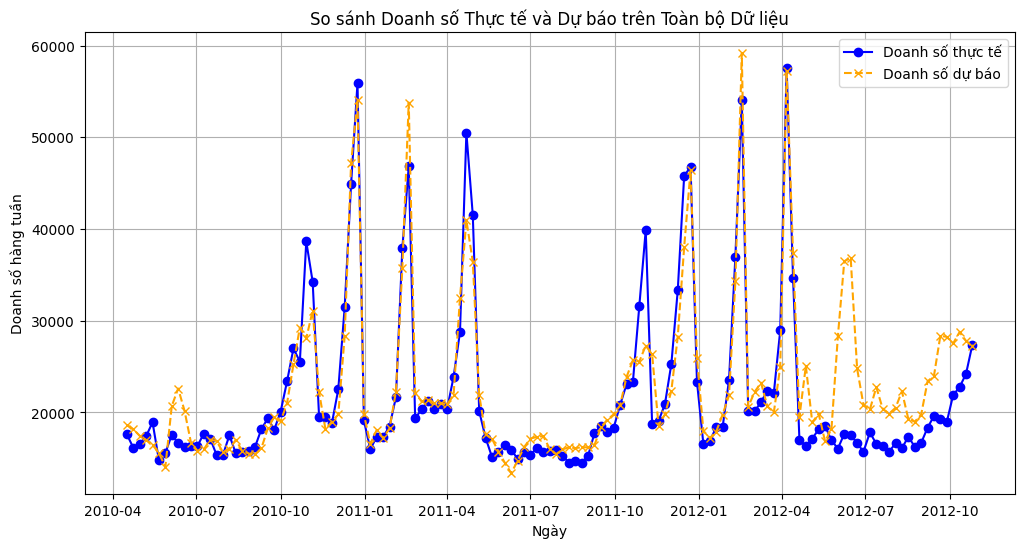

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Doanh số dự báo cho 10 tuần tiếp theo:
            Predicted_Weekly_Sales
2012-11-02            26070.458984
2012-11-09            25108.490234
2012-11-16            23011.781250
2012-11-23            21183.037109
2012-11-30            19766.001953
2012-12-07            19875.158203
2012-12-14            22655.480469
2012-12-21            28000.296875
2012-12-28            36267.007812
2013-01-04            37667.121094


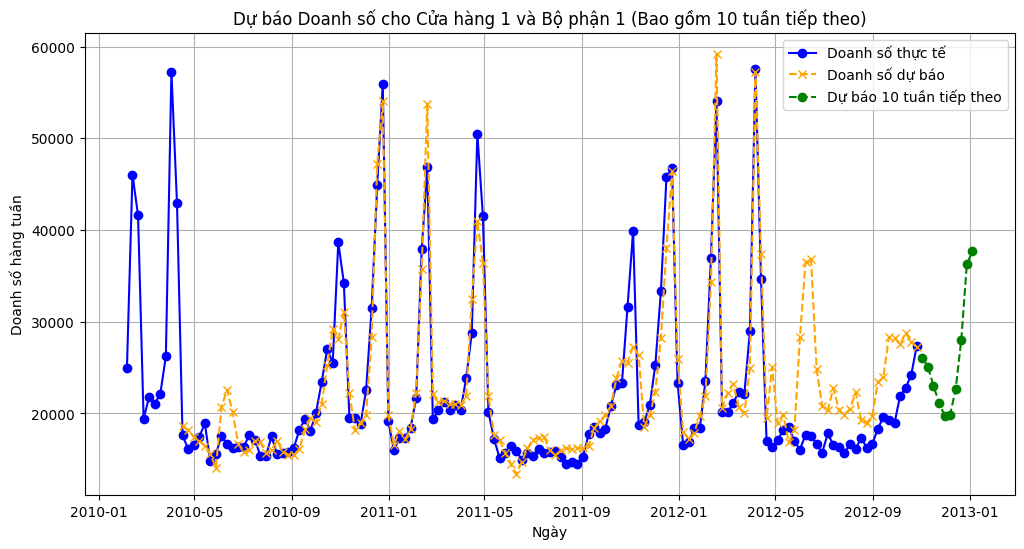

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Tầm quan trọng của các biến:
        Variable   Coefficient
2     Fuel_Price  2.412553e+07
3            CPI  1.645902e+06
10     MarkDown5  1.339801e+06
0          Sales  8.944308e+05
5           Size  0.000000e+00
8      MarkDown3 -1.791595e+05
6      MarkDown1 -2.013776e+05
7      MarkDown2 -1.063846e+06
9      MarkDown4 -2.062472e+06
4   Unemployment -7.818952e+06
1    Temperature -1.752396e+07


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Đọc tệp CSV
file_path = "../dataset/data.csv"
data = pd.read_csv(file_path)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Lọc dữ liệu cho Cửa hàng 1 và Bộ phận 1
store_1_dept_1 = data[(data['Store'] == 1) & (data['Dept'] == 1)]
store_1_dept_1 = store_1_dept_1.sort_index()  # Sắp xếp theo thời gian

sales_data = store_1_dept_1['Weekly_Sales']
exogenous_vars = store_1_dept_1[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size',
                                 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']]

# Xử lý giá trị thiếu nếu có
exogenous_vars = exogenous_vars.fillna(0)

# Chuẩn hóa dữ liệu
scaler_sales = MinMaxScaler(feature_range=(0, 1))
scaler_exog = MinMaxScaler(feature_range=(0, 1))

sales_scaled = scaler_sales.fit_transform(sales_data.values.reshape(-1, 1))
exog_scaled = scaler_exog.fit_transform(exogenous_vars)

# Kết hợp doanh số và biến ngoại sinh
dataset = np.concatenate([sales_scaled, exog_scaled], axis=1)

# Hàm tạo dữ liệu cho mô hình LSTM
def create_dataset(data, look_back=10):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        Y.append(data[i + look_back, 0])  # Doanh số là cột đầu tiên
    return np.array(X), np.array(Y)

look_back = 10  # Sử dụng 10 tuần dữ liệu để dự báo tuần tiếp theo

# Tạo dữ liệu cho mô hình
X, y = create_dataset(dataset, look_back)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

n_features = dataset.shape[1]  # Số lượng biến đặc trưng

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, n_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)

# Dự báo trên toàn bộ dữ liệu
y_pred_scaled = model.predict(X)
y_pred = scaler_sales.inverse_transform(y_pred_scaled)
y_actual = scaler_sales.inverse_transform(y.reshape(-1, 1))

# Tính toán RMSE, MAE, MAPE trên tập kiểm tra
y_test_pred = y_pred[train_size:]
y_test_actual = y_actual[train_size:]

rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
mae = mean_absolute_error(y_test_actual, y_test_pred)
mape = np.mean(np.abs((y_test_actual - y_test_pred) / y_test_actual)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

# Vẽ đồ thị so sánh trên toàn bộ dữ liệu
dates = sales_data.index[look_back:]

plt.figure(figsize=(12, 6))
plt.plot(dates, y_actual, label='Doanh số thực tế', color='blue', marker='o', linestyle='-')
plt.plot(dates, y_pred, label='Doanh số dự báo', color='orange', marker='x', linestyle='--')
plt.xlabel('Ngày')
plt.ylabel('Doanh số hàng tuần')
plt.title('So sánh Doanh số Thực tế và Dự báo trên Toàn bộ Dữ liệu')
plt.legend()
plt.grid()
plt.show()

# Dự báo cho 10 tuần tiếp theo
n_weeks_to_predict = 10

last_data = dataset[-look_back:]  # Lấy 10 tuần dữ liệu cuối cùng
predictions_future = []
future_dates = []

for i in range(n_weeks_to_predict):
    # Dự báo tuần tiếp theo
    next_pred_scaled = model.predict(last_data.reshape(1, look_back, n_features))
    next_pred = scaler_sales.inverse_transform(next_pred_scaled)[0][0]
    predictions_future.append(next_pred)

    # Ngày cho tuần tiếp theo
    next_date = sales_data.index[-1] + pd.Timedelta(weeks=i+1)
    future_dates.append(next_date)

    # Giả định biến ngoại sinh trong tương lai bằng giá trị trung bình
    future_exog_scaled = np.mean(exog_scaled[-look_back:], axis=0).reshape(1, -1)
    # Tạo dữ liệu cho lần dự báo tiếp theo
    next_input = np.concatenate([next_pred_scaled, future_exog_scaled], axis=1)
    last_data = np.vstack([last_data[1:], next_input])

# Tạo DataFrame cho kết quả dự báo tương lai
future_df = pd.DataFrame({'Predicted_Weekly_Sales': predictions_future}, index=future_dates)

# In kết quả dự báo cho 10 tuần tiếp theo
print("\nDoanh số dự báo cho 10 tuần tiếp theo:")
print(future_df)

# Vẽ đồ thị bao gồm dự báo 10 tuần tiếp theo
plt.figure(figsize=(12, 6))
plt.plot(sales_data.index, sales_data.values, label='Doanh số thực tế', color='blue', marker='o', linestyle='-')
plt.plot(dates, y_pred, label='Doanh số dự báo', color='orange', marker='x', linestyle='--')
plt.plot(future_df.index, future_df['Predicted_Weekly_Sales'], label='Dự báo 10 tuần tiếp theo', color='green', marker='o', linestyle='--')
plt.xlabel('Ngày')
plt.ylabel('Doanh số hàng tuần')
plt.title('Dự báo Doanh số cho Cửa hàng 1 và Bộ phận 1 (Bao gồm 10 tuần tiếp theo)')
plt.legend()
plt.grid()
plt.show()

# ==============================
# Step 4: Tính tầm quan trọng của các biến mà không chia theo tuần
# ==============================

# Chuẩn bị dữ liệu để tính tầm quan trọng
X_val = X_test
y_val = y_test_actual.flatten()
X_val_reshaped = X_val.reshape(X_val.shape[0], look_back * n_features)

# Tính lỗi gốc (baseline error)
baseline_predictions = model.predict(X_val)
baseline_predictions = scaler_sales.inverse_transform(baseline_predictions).flatten()
baseline_mse = mean_squared_error(y_val, baseline_predictions)

# Tạo danh sách tên biến
variable_names = ['Sales'] + list(exogenous_vars.columns)

# Tạo từ điển lưu chỉ số của các biến
variable_indices = {}
for idx, var in enumerate(variable_names):
    indices = [i * n_features + idx for i in range(look_back)]
    variable_indices[var] = indices

# Khởi tạo từ điển lưu tầm quan trọng
importances = {}

# Tính tầm quan trọng cho từng biến
for var in variable_names:
    X_permuted = X_val_reshaped.copy()
    # Hoán vị các giá trị của biến trên tất cả các thời điểm
    np.random.seed(42)  # Để tái lập kết quả
    permuted_indices = variable_indices[var]
    X_permuted[:, permuted_indices] = np.random.permutation(X_permuted[:, permuted_indices])
    # Chuyển đổi về dạng 3D
    X_permuted_3d = X_permuted.reshape(X_permuted.shape[0], look_back, n_features)
    # Dự báo với dữ liệu đã hoán vị
    permuted_predictions = model.predict(X_permuted_3d)
    permuted_predictions = scaler_sales.inverse_transform(permuted_predictions).flatten()
    # Tính lỗi mới
    permuted_mse = mean_squared_error(y_val, permuted_predictions)
    # Tầm quan trọng là sự gia tăng lỗi
    importance = permuted_mse - baseline_mse
    importances[var] = importance

# Tạo DataFrame cho tầm quan trọng của các biến
coef_df = pd.DataFrame({
    'Variable': list(importances.keys()),
    'Coefficient': list(importances.values())
}).sort_values(by='Coefficient', ascending=False)

# In tầm quan trọng của từng biến
print("\nTầm quan trọng của các biến:")
print(coef_df)


FINAL


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta

In [3]:
# Step 1: Read the CSV file
file_path = "../dataset/data.csv"
data = pd.read_csv(file_path)

# Convert 'Date' column to datetime and set it as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


In [4]:
# Step 2: Drop the 'IsHoliday' column and scale the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Weekly_Sales']])



In [5]:
# Step 3: Prepare data for LSTM (timesteps = 10 for previous 10 weeks)
def create_dataset(data, time_step=10):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10
X_data, y_data = create_dataset(scaled_data, time_step)

# Reshape input to be [samples, time steps, features] for LSTM
X_data = X_data.reshape((X_data.shape[0], X_data.shape[1], 1))


In [6]:
# Step 4: Train/test split
train_size = int(len(X_data) * 0.8)
X_train, X_test = X_data[:train_size], X_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]



In [7]:
# Step 5: Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)


Epoch 1/30


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10316/10316 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.0037
Epoch 2/30
10316/10316 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.0025
Epoch 3/30
10316/10316 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 0.0025
Epoch 4/30
10316/10316 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0024
Epoch 5/30
10316/10316 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 0.0024
Epoch 6/30
10316/10316 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.0024
Epoch 7/30
10316/10316 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0024
Epoch 8/30
10316/10316 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 0.0023
Epoch 9/30
10316/10316 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 0.0023
Epoch 10/30
10316/10316 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 0.0023
Epoch 11/30
10316/10316 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 0.0023
Epoch 12/30
10316/10316 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.0022
Epoch 13/30
10316/10316 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0022
Epoch 14/30
10316/10316 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 0.002

In [8]:
# Step 6: Evaluate the model
y_pred_scaled = model.predict(X_test)

# Inverse transform to get actual predictions
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE, MAE, MAPE
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")


2580/2580 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
RMSE: 3021.52
MAE: 1379.41
MAPE: 4230.92%


In [9]:
# Step 7: Predict sales for Store 1 and Dept 1 (rolling predictions for 5 weeks)
store_1_dept_1 = data[(data['Store'] == 1) & (data['Dept'] == 1)]
X_store_dept_scaled = scaler.transform(store_1_dept_1[['Weekly_Sales']].values)

# Prepare the data for LSTM (rolling window)
X_store_dept, y_store_dept = create_dataset(X_store_dept_scaled, time_step)

# Reshape for LSTM
X_store_dept = X_store_dept.reshape((X_store_dept.shape[0], time_step, 1))

# Predict sales
store_dept_sales_pred_scaled = model.predict(X_store_dept)
store_dept_sales_pred = scaler.inverse_transform(store_dept_sales_pred_scaled.reshape(-1, 1))

# Actual sales for Store 1 and Dept 1
store_dept_sales_actual = store_1_dept_1['Weekly_Sales'].values[-len(store_dept_sales_pred):]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


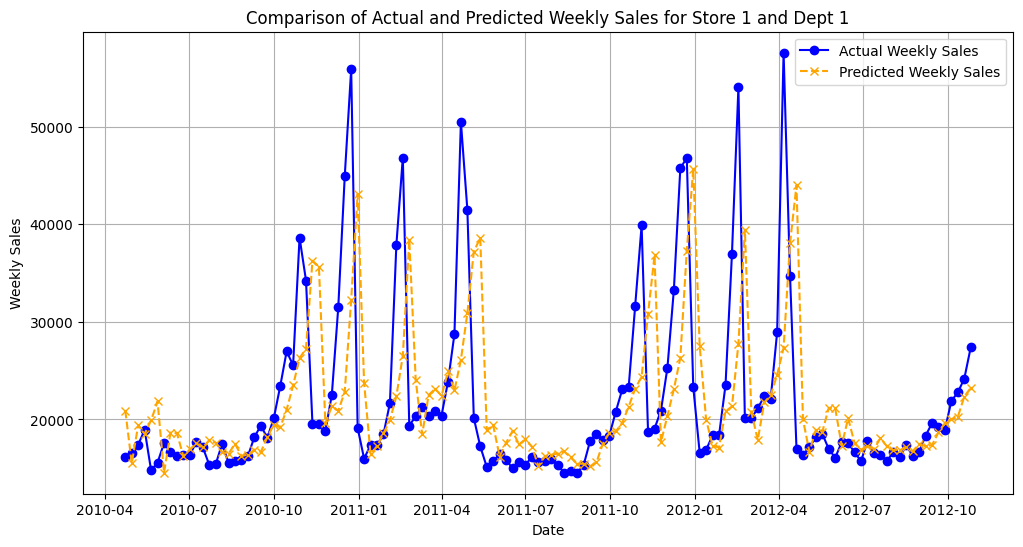

In [10]:
# Step 8: Plot actual vs predicted sales for Store 1 and Dept 1
plt.figure(figsize=(12, 6))
plt.plot(store_1_dept_1.index[-len(store_dept_sales_pred):], store_dept_sales_actual, label='Actual Weekly Sales', color='blue', marker='o', linestyle='-')
plt.plot(store_1_dept_1.index[-len(store_dept_sales_pred):], store_dept_sales_pred, label='Predicted Weekly Sales', color='orange', marker='x', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Comparison of Actual and Predicted Weekly Sales for Store 1 and Dept 1')
plt.legend()
plt.grid()
plt.show()

In [11]:
# Step 9: Predict the next 5 weeks
predicted_weeks = []
predicted_sales = []

# Get the last 10 weeks of data for the initial prediction
rolling_data = store_1_dept_1.iloc[-10:].copy()
rolling_scaled_data = scaler.transform(rolling_data[['Weekly_Sales']].values)

for i in range(5):  # Predict next 5 weeks
    X_rolling = rolling_scaled_data[-time_step:].reshape((1, time_step, 1))
    predicted_next_week_scaled = model.predict(X_rolling)
    predicted_next_week = scaler.inverse_transform(predicted_next_week_scaled)[0][0]

    predicted_sales.append(predicted_next_week)
    next_week_date = rolling_data.index[-1] + timedelta(weeks=1)
    predicted_weeks.append(next_week_date)
    
    print(f"Predicted sales for the week starting on {next_week_date.strftime('%Y-%m-%d')}: {predicted_next_week:.2f}")
    
    # Update rolling_data with predicted value
    new_row = pd.DataFrame({'Weekly_Sales': [predicted_next_week]}, index=[next_week_date])
    rolling_data = pd.concat([rolling_data, new_row])

    rolling_scaled_data = scaler.transform(rolling_data[['Weekly_Sales']].values)



C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted sales for the week starting on 2012-11-02: 28476.60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted sales for the week starting on 2012-11-09: 29541.15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted sales for the week starting on 2012-11-16: 31274.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted sales for the week starting on 2012-11-23: 33307.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X doe

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted sales for the week starting on 2012-11-30: 34833.96


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [12]:
# Print all predicted sales for the next 5 weeks
print("\nFinal Predictions for the next 5 weeks:")
for week, sales in zip(predicted_weeks, predicted_sales):
    print(f"Week starting {week.strftime('%Y-%m-%d')}: Predicted Sales = {sales:.2f}")



Final Predictions for the next 5 weeks:
Week starting 2012-11-02: Predicted Sales = 28476.60
Week starting 2012-11-09: Predicted Sales = 29541.15
Week starting 2012-11-16: Predicted Sales = 31274.97
Week starting 2012-11-23: Predicted Sales = 33307.59
Week starting 2012-11-30: Predicted Sales = 34833.96


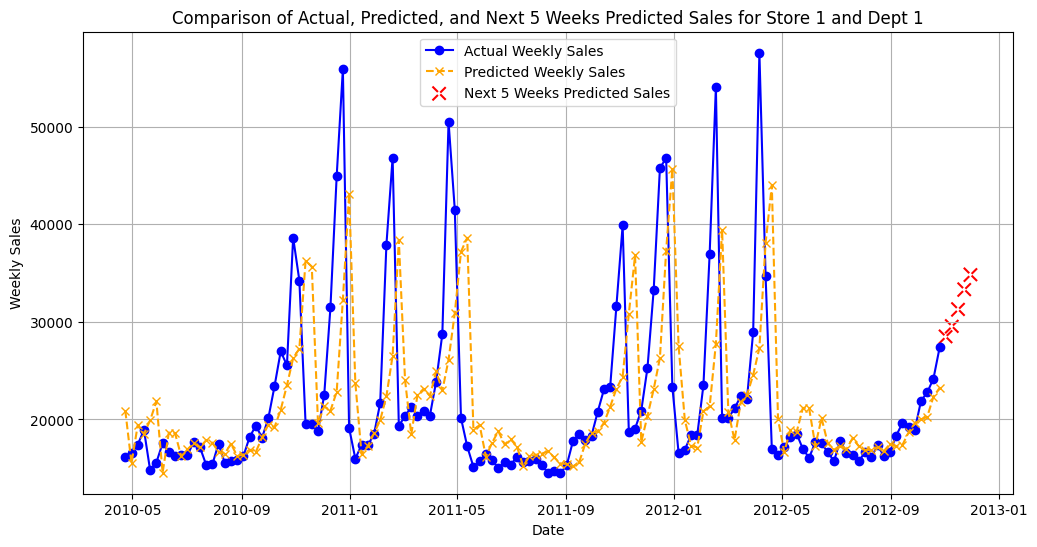

In [13]:
# Step 10: Plot the next 5 weeks predictions
plt.figure(figsize=(12, 6))
plt.plot(store_1_dept_1.index[-len(store_dept_sales_pred):], store_dept_sales_actual, label='Actual Weekly Sales', color='blue', marker='o', linestyle='-')
plt.plot(store_1_dept_1.index[-len(store_dept_sales_pred):], store_dept_sales_pred, label='Predicted Weekly Sales', color='orange', marker='x', linestyle='--')
plt.scatter(predicted_weeks, predicted_sales, color='red', marker='x', s=100, label='Next 5 Weeks Predicted Sales', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Comparison of Actual, Predicted, and Next 5 Weeks Predicted Sales for Store 1 and Dept 1')
plt.legend()
plt.grid()
plt.show()


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta

# Step 1: Read the CSV file
file_path = "../dataset/data.csv"
data = pd.read_csv(file_path)

# Convert 'Date' column to datetime and set it as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Step 2: Drop the 'IsHoliday' column and scale the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Weekly_Sales']])

# Step 3: Prepare data for LSTM (timesteps = 10 for previous 10 weeks)
def create_dataset(data, time_step=10):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10
X_data, y_data = create_dataset(scaled_data, time_step)

# Reshape input to be [samples, time steps, features] for LSTM
X_data = X_data.reshape((X_data.shape[0], X_data.shape[1], 1))

# Step 4: Train/test split
train_size = int(len(X_data) * 0.8)
X_train, X_test = X_data[:train_size], X_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

# Step 5: Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Step 6: Evaluate the model
y_pred_scaled = model.predict(X_test)

# Inverse transform to get actual predictions
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE, MAE, MAPE
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

# Step 7: Predict sales for Store 1 and Dept 1 (rolling predictions for 5 weeks)
store_1_dept_1 = data[(data['Store'] == 1) & (data['Dept'] == 1)]
X_store_dept_scaled = scaler.transform(store_1_dept_1[['Weekly_Sales']].values)

# Prepare the data for LSTM (rolling window)
X_store_dept, y_store_dept = create_dataset(X_store_dept_scaled, time_step)

# Reshape for LSTM
X_store_dept = X_store_dept.reshape((X_store_dept.shape[0], time_step, 1))

# Predict sales
store_dept_sales_pred_scaled = model.predict(X_store_dept)
store_dept_sales_pred = scaler.inverse_transform(store_dept_sales_pred_scaled.reshape(-1, 1))

# Actual sales for Store 1 and Dept 1
store_dept_sales_actual = store_1_dept_1['Weekly_Sales'].values[-len(store_dept_sales_pred):]

# Step 8: Plot actual vs predicted sales for Store 1 and Dept 1
plt.figure(figsize=(12, 6))
plt.plot(store_1_dept_1.index[-len(store_dept_sales_pred):], store_dept_sales_actual, label='Actual Weekly Sales', color='blue', marker='o', linestyle='-')
plt.plot(store_1_dept_1.index[-len(store_dept_sales_pred):], store_dept_sales_pred, label='Predicted Weekly Sales', color='orange', marker='x', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Comparison of Actual and Predicted Weekly Sales for Store 1 and Dept 1')
plt.legend()
plt.grid()
plt.show()

# Step 9: Predict the next 5 weeks
predicted_weeks = []
predicted_sales = []

# Get the last 10 weeks of data for the initial prediction
rolling_data = store_1_dept_1.iloc[-10:].copy()
rolling_scaled_data = scaler.transform(rolling_data[['Weekly_Sales']].values)

for i in range(5):  # Predict next 5 weeks
    X_rolling = rolling_scaled_data[-time_step:].reshape((1, time_step, 1))
    predicted_next_week_scaled = model.predict(X_rolling)
    predicted_next_week = scaler.inverse_transform(predicted_next_week_scaled)[0][0]

    predicted_sales.append(predicted_next_week)
    next_week_date = rolling_data.index[-1] + timedelta(weeks=1)
    predicted_weeks.append(next_week_date)
    
    print(f"Predicted sales for the week starting on {next_week_date.strftime('%Y-%m-%d')}: {predicted_next_week:.2f}")
    
    # Update rolling_data with predicted value
    new_row = pd.DataFrame({'Weekly_Sales': [predicted_next_week]}, index=[next_week_date])
    rolling_data = pd.concat([rolling_data, new_row])

    rolling_scaled_data = scaler.transform(rolling_data[['Weekly_Sales']].values)

# Step 10: Plot the next 5 weeks predictions
plt.figure(figsize=(12, 6))
plt.plot(store_1_dept_1.index[-len(store_dept_sales_pred):], store_dept_sales_actual, label='Actual Weekly Sales', color='blue', marker='o', linestyle='-')
plt.plot(store_1_dept_1.index[-len(store_dept_sales_pred):], store_dept_sales_pred, label='Predicted Weekly Sales', color='orange', marker='x', linestyle='--')
plt.scatter(predicted_weeks, predicted_sales, color='red', marker='x', s=100, label='Next 5 Weeks Predicted Sales', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Comparison of Actual, Predicted, and Next 5 Weeks Predicted Sales for Store 1 and Dept 1')
plt.legend()
plt.grid()
plt.show()

# Print all predicted sales for the next 5 weeks
print("\nFinal Predictions for the next 5 weeks:")
for week, sales in zip(predicted_weeks, predicted_sales):
    print(f"Week starting {week.strftime('%Y-%m-%d')}: Predicted Sales = {sales:.2f}")


Epoch 1/50


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 5777/10316 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0040

KeyboardInterrupt: 